In [ ]:
import tensorflow as tf
import os
import time
import pathlib
import datetime
from matplotlib import pyplot as plt
from IPython import display

In [ ]:
dataset = 'maps'

In [ ]:
dataset_file = "{}.tar.gz".format(dataset)
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(dataset_file)

In [ ]:
download_zip = tf.keras.utils.get_file(fname = dataset_file,origin = dataset_url,extract =True)

250242400/250242400 [==============================] - 123s 0us/step


In [ ]:
download_zip = pathlib.Path(download_zip)
path = download_zip.parent/dataset

In [ ]:
path

PosixPath('/root/.keras/datasets/maps')

In [ ]:
list(path.parent.iterdir())

[PosixPath('/root/.keras/datasets/maps'),
 PosixPath('/root/.keras/datasets/maps.tar.gz')]

In [ ]:
sample = tf.io.read_file(str(path / 'train/1095.jpg'))
sample = tf.io.decode_jpeg(sample)

In [ ]:
sample.shape

TensorShape([600, 1200, 3])

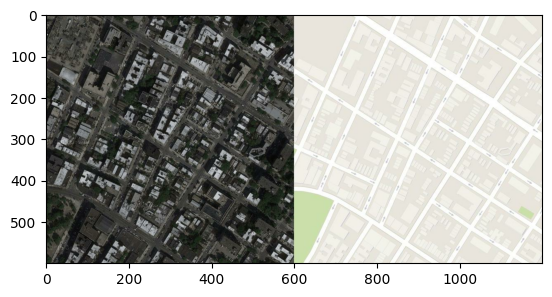

In [ ]:
plt.figure()
plt.imshow(sample)

In [ ]:
def load_image(img_file):
  img = tf.io.read_file(img_file)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img,[256,512])
  print(img.shape)

  width = tf.shape(img)[1]
  width = width // 2
  original_img = img[:, :width, :]
  transformed_img = img[:, width:, :]

  original_img =tf.cast(original_img, tf.float32)
  transformed_img = tf.cast(transformed_img, tf.float32)

  return original_img, transformed_img

(256, 512, 3)


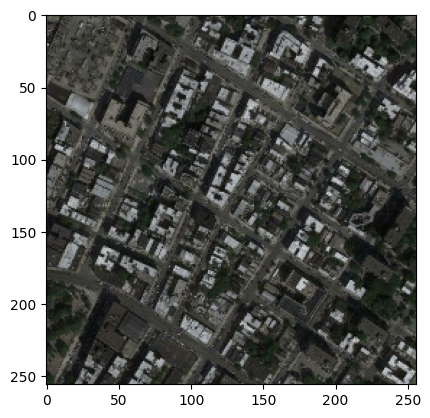

In [ ]:
original_img , transformed_img = load_image(str(path/ 'train/1095.jpg'))
plt.figure()
plt.imshow(original_img/255.0)

In [ ]:
quantity_training = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
quantity_training

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
quantity_training = len(list(quantity_training))
quantity_training

1096

In [ ]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [ ]:
def resize(original_img,transformed_img,width, height):
  original_img = tf.image.resize(original_img,[width,height],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  transformed_img = tf.image.resize(transformed_img,[width,height],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return original_img , transformed_img

In [ ]:
def normalize(original_img,transformed_img):
  original_img = (original_img /127.5) - 1
  transformed_img = (transformed_img /127.5) -1
  return original_img , transformed_img

In [ ]:
def random_crop(original_img,transformed_img):
  stacked_img = tf.stack([original_img,transformed_img],axis = 0)
  crop_img = tf.image.random_crop(stacked_img,size = [2, img_width,img_height,3])
  return crop_img[0],crop_img[1]

In [ ]:
@tf.function()
def random_jitter(original_img,transformed_img):
  original_img , transformed_img = resize(original_img,transformed_img,286,286)
  original_img , transformed_img = random_crop(original_img,transformed_img)
  if tf.random.uniform(()) > 0.5 :
    original_img = tf.image.flip_left_right(original_img)
    transformed_img = tf.image.flip_left_right(transformed_img)
  return original_img, transformed_img

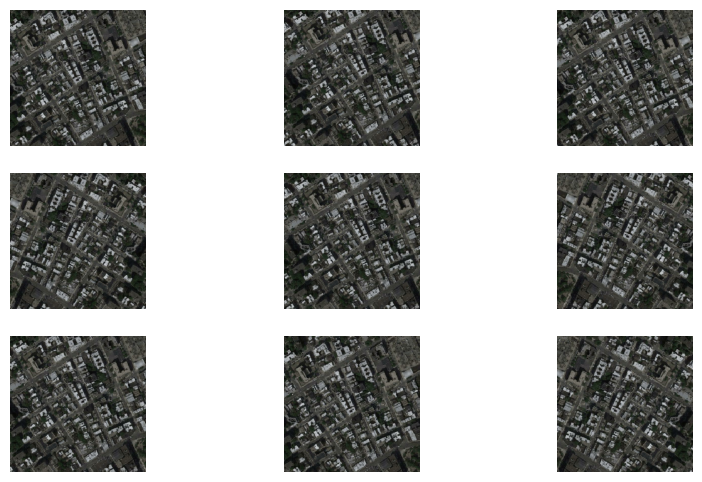

In [ ]:
plt.figure(figsize= (10,6))
for i in range(9):
  j_original, j_transformed = random_jitter(original_img, transformed_img)
  plt.subplot(3,3,i+1)
  plt.imshow(j_original / 255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_training_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = random_jitter(original_img, transformed_img)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [ ]:
def load_testing_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = resize(original_img, transformed_img, img_width,img_height)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [ ]:
training_datatset  = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
training_datatset = training_datatset.map(load_training_images,num_parallel_calls=tf.data.AUTOTUNE)
training_datatset = training_datatset.shuffle(buffer_size)
training_datatset = training_datatset.batch(batch_size)

(256, 512, None)


In [ ]:
training_datatset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [ ]:
try:
  testing_dataset = tf.data.Dataset.list_files(str(path /'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  testing_dataset = tf.data.Dataset.list_files(str(path /'val/*.jpg'))
testing_dataset = testing_dataset.map(load_testing_images)
testing_dataset = testing_dataset.batch(batch_size)

(256, 512, None)


In [ ]:
def encode(filters,size,apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0,0.2)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters,size,strides = 2 , padding = 'same',kernel_initializer=initializer,use_bias = False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
down_model = encode(3,4)
down_result = down_model(tf.expand_dims(original_img,0))
print(down_result.shape)

(1, 128, 128, 3)


In [ ]:
def decode(filters,size,apply_droupout = False):
  initializer = tf.random_normal_initializer(0,0.2)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters,size,strides = 2 ,padding ='same',kernel_initializer=initializer,use_bias = False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_droupout:
    result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.ReLU())
  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape = [256,256,3])

  downsampling = [
      encode(64,4,apply_batchnorm=False),
      encode(128,4),
      encode(256,4),
      encode(512,4),
      encode(512,4),
      encode(512,4),
      encode(512,4),
      encode(512,4)
  ]
  upsampling = [
       decode(512,4,apply_droupout=True),
       decode(512,4,apply_droupout=True),
       decode(512,4,apply_droupout=True),
       decode(512,4),
       decode(256,4),
       decode(128,4),
       decode(64,4)
  ]
  output_channel = 3
  initializer = tf.random_normal_initializer(0.,0.02)
  last =tf.keras.layers.Conv2DTranspose(output_channel,4,2,padding='same',kernel_initializer=initializer,activation='tanh')
  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  for up,skip in zip(upsampling,skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x,skip])
  x = last(x)
  return tf.keras.Model(inputs =inputs , outputs = x)

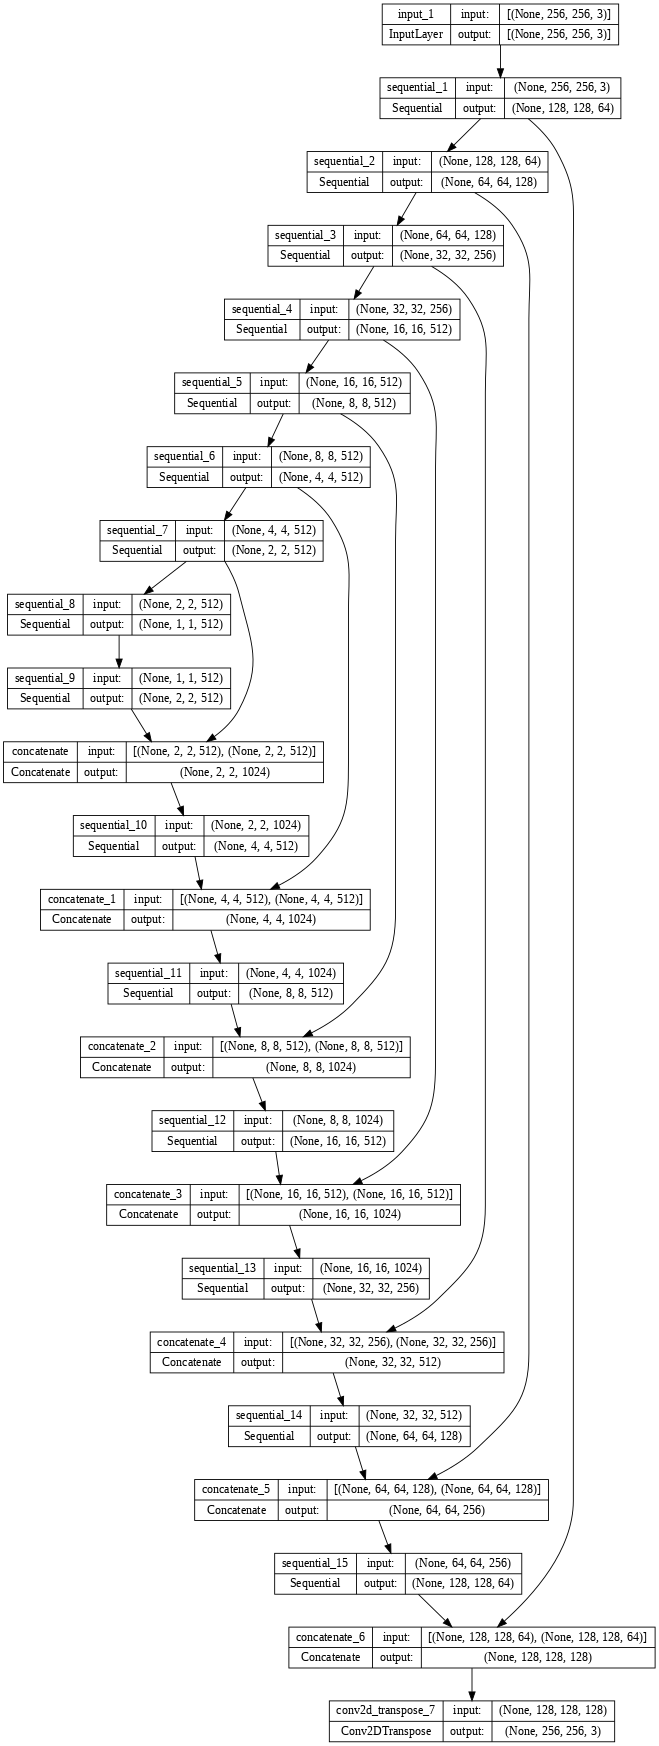

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator,show_shapes=True,dpi = 64)

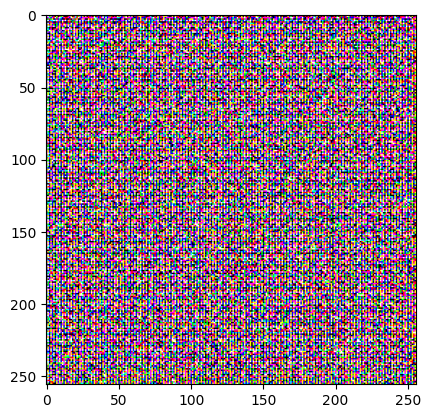

In [ ]:
g_output = generator(original_img[tf.newaxis,...],training=False)
plt.imshow(g_output[0,...])

In [ ]:
lr = 0.0002
beta1, beta2 = 0.5,0.999
lambda_ = 100

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits= True)

In [ ]:
def generator_loss(d_generated_output, g_output, target):
  gan_loss = loss(tf.ones_like(d_generated_output),d_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target-g_output))
  g_loss_total = gan_loss + (lambda_ *l1_loss)
  return gan_loss, l1_loss, g_loss_total

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  original = tf.keras.layers.Input([256,256,3])
  transformed = tf.keras.layers.Input([256,256,3])
  x = tf.keras.layers.concatenate([original,transformed])
  down1 = encode(64,4,False)(x)
  down2 = encode(128,4)(down1)
  down3 = encode(256,4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zeropad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
  last = tf.keras.layers.Conv2D(1,4,1,kernel_initializer=initializer)(zeropad2)

  return tf.keras.Model(inputs=[original,transformed],outputs = last)

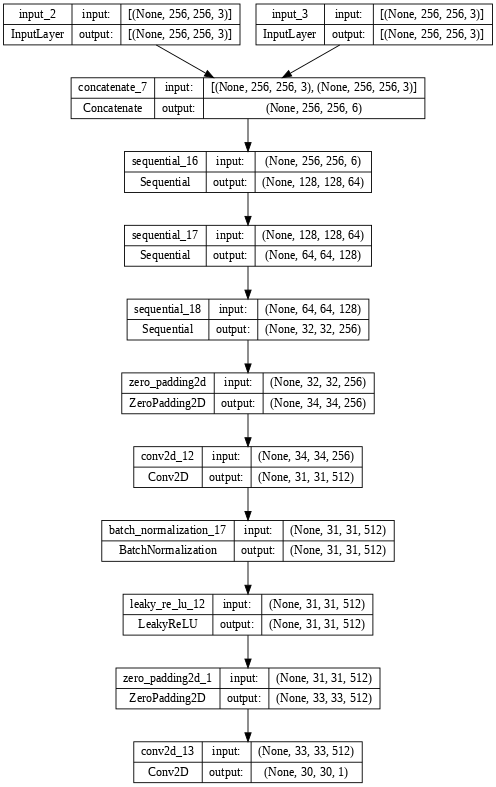

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator,show_shapes=True,dpi=64)

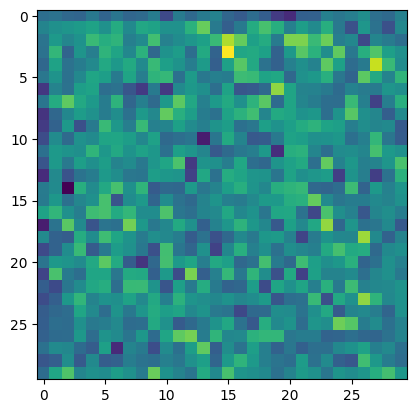

In [ ]:
d_output = discriminator([original_img[tf.newaxis,...],g_output],training=False)
plt.imshow(d_output[0,...,-1])

In [ ]:
def discriminator_loss(d_real_output,d_generated_output):
  real_loss = loss(tf.ones_like(d_real_output),d_real_output)
  generated_loss = loss(tf.zeros_like(d_generated_output),d_generated_output)
  total_loss = real_loss + generated_loss
  return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr,beta1,beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr,beta1,beta2)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generateImage(model,test_input,real_image,step=None):
  generated_img = generator(test_input,training = True)

  plt.figure(figsize=(12,8))

  img_list = [test_input[0], real_image[0],generated_img[0]]
  title = ['Input Image','Real Image', 'Generated Image']

  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(title[i])
    plt.imshow(img_list[i]*0.5 + 0.5)
    plt.axis('off')

  if step is not None:
    plt.savefig('result_pix2pix_step_{}.png'.format(step),bbox_inches='tight')

  plt.show()

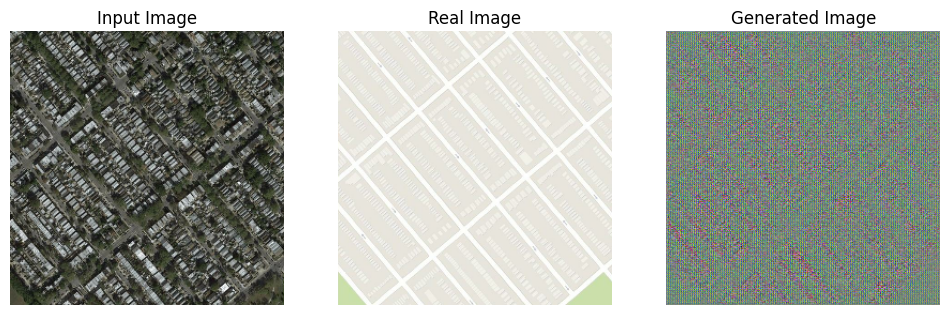

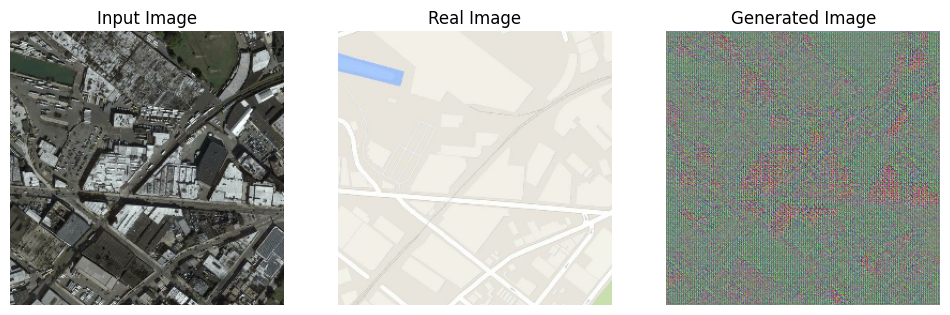

In [ ]:
for input_example, real_example in testing_dataset.take(2):
  generateImage(generator,input_example, real_example)

In [ ]:
path_log = 'logs/'
metrics = tf.summary.create_file_writer(path_log + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def training_step(input_img,real,step):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img,training = True)

    d_output_real = discriminator([input_img,real],training=True)
    d_output_fake = discriminator([input_img,g_output],training=True)

    g_total_loss, g_loss_gan, g_loss_l1 = generator_loss(d_output_fake,g_output,real)
    d_loss = discriminator_loss(d_output_real,d_output_fake)

  generator_gradients = g_tape.gradient(g_total_loss, generator.trainable_variables)
  discriminator_gradient = d_tape.gradient(d_loss, discriminator.trainable_variables)


  generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradient,discriminator.trainable_variables))

  with metrics.as_default():
      tf.summary.scalar('g_total_loss',g_total_loss,step=step//1000)
      tf.summary.scalar('g_loss_gan',g_loss_gan,step=step//1000)
      tf.summary.scalar('g_loss_l1',g_loss_l1,step=step//1000)
      tf.summary.scalar('d_loss',d_loss,step=step//1000)

In [ ]:
def train(training_dataset,testing_datatset,steps):
  test_input, real_input = next(iter(testing_dataset.take(1)))
  start = time.time()

  for step, (input_img , real_img) in training_dataset.repeat().take(steps).enumerate():
    if step % 1000 == 0:
      display.clear_output(wait = True)
      if step != 0 :
        print(f'Time taken to run 1000 steps:{time.time() - start:.2f} seconds\n')
      start = time.time()
      generateImage(generator, test_input,real_input,step)
      print(f'Step: {step//1000}k')
    training_step(input_img,real_img,step)
    if(step + 1) % 10 ==0:
      print('.', end= '',flush = True)
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      generator.save_weights('model_pix2pix.h5')

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {path_log}

Time taken to run 1000 steps:101.56 seconds



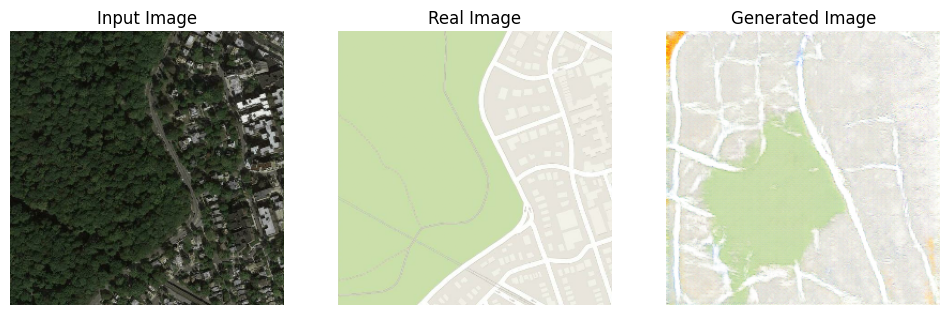

Step: 4k
....................................................................................................

In [ ]:
train(training_datatset,testing_dataset,steps=5000)